# Implementing Basis Functions for Gillan's Method

[1] https://doi.org/10.1080/00268977900102861

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define a grid:

In [2]:
radius = 2
npts = 16
dx = radius/npts
i = np.arange(0, npts)
x = np.arange(0, npts) * dx

Defines the number of basis functions and their corresponding nodes:

In [3]:
nbasis = 4
nodes_index = np.round(np.linspace(1, (npts/2)+1, num=nbasis)).astype(int)
nodes_index = np.asarray([2, 4, 6, 8]).astype(int)
nodes = i[nodes_index]
print(nodes_index)
print(i)
print(nodes)

[2 4 6 8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[2 4 6 8]


Initialise the Basis functions and related values:

In [4]:
P = np.zeros((npts, nbasis), dtype=np.float64) # Basis Function Eq(17) of [1]
Q = np.zeros_like(P) # Conjugate Basis Function Eq(18) of [1]
R = np.zeros((nbasis, nbasis), dtype=np.float64) # Eq (20) of [1]
kron = np.zeros_like(R) # Eq (19) of [1]

Basis function $P$ is defined with the following cases: 

(1) $P_\alpha^i = 0$ when $1 \leq i \leq i_{\alpha-2}$

(2) $P_\alpha^i = \frac{i - i_{\alpha-2}}{i_{\alpha-1} - i_{\alpha-2}}$ when $i_{\alpha-2} \leq i \leq i_{\alpha-1}$

(3) $P_\alpha^i = \frac{i_\alpha - i}{i_{\alpha} - i_{\alpha-1}}$ when $i_{\alpha-1} \leq i \leq i_{\alpha}$

(4) $P_\alpha^i = 0$ when $i_{\alpha} \leq i \leq N$

and for the case $P_1^i$ ($\alpha = 1$):

(5) $P_1^i = \frac{i_1 - i}{i_1}$ when $1 \leq i \leq i_1$

(6) $P_1^i = 0$ when $i_1 \leq i \leq N$

where $i_\alpha$ are the points at which a node is defined (var: nodes).
Since the arrays are initialised with 0, we only really need to implement (2), (3) and (5).

This paper was written most likely for Fortran where arrays start at 1, but in Python arrays are 0-indexed! Keep that in mind.

In [5]:
# For the case \alpha = 0 and idx = 0
P[0,0] = 1
# For \alpha = 0 and the rest of the idx
for idx in range(1, npts):
    if 1.0 <= i[idx] <= nodes[0]:
        P[idx, 0] = (nodes[0] - i[idx]) / nodes[0]

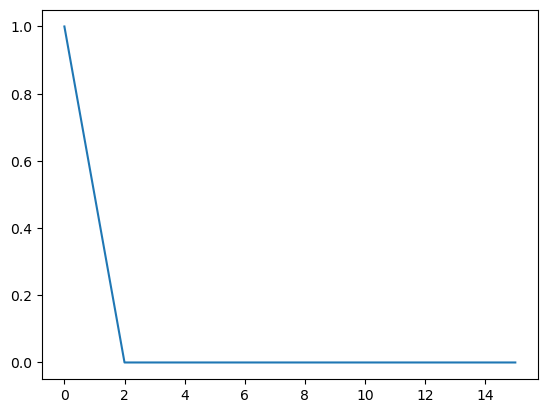

In [6]:
plt.plot(i, P[..., 0])
plt.show()

In [7]:
# Rest of the \alpha cases
for a in range(1, nbasis):
    for idx in range(0, npts):
        if nodes[a-2] <= i[idx] <= nodes[a-1]:
            P[idx, a] = (i[idx] - nodes[a-2])/(nodes[a-1] - nodes[a-2])
        elif nodes[a-1] <= i[idx] <= nodes[a]:
            P[idx, a] = (nodes[a] - i[idx])/(nodes[a] - nodes[a-1])

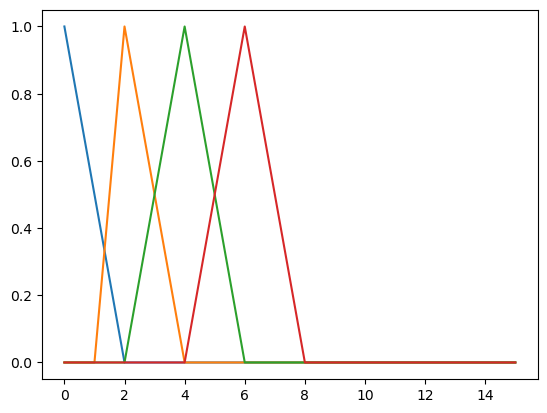

In [8]:
for a in range(0, nbasis):
    plt.plot(i, P[..., a])
plt.show()

Implementing equation 20 of [1] - $R_{\alpha\beta} = \sum_i P_\alpha^i P_\beta^i$

In [9]:
Pa = P.copy()
Pb = P.copy()
for a in range(nbasis):
    for b in range(nbasis):
        R[a,b] = (Pa[a] * Pb[b]).sum()

The inverse of R - $B_{\alpha\beta}$

In [10]:
B = np.linalg.pinv(R)

Implementing equation 18 of [1] - $Q_\alpha^i = \sum_\beta B_{\alpha\beta}P_\beta^i$

In [11]:
for a in range(nbasis):
    for b in range(nbasis):
        Q[:,a] = (B[a,b] * P[:,b])

Implementing equation 20 of [1] - $\sum_i Q_\alpha^iP_\beta^i = \delta_{\alpha\beta}$

In [12]:
for a in range(nbasis):
    for b in range(nbasis):
        kron[a,b] = (Q[:,a] * P[:,b]).sum()

kron should be the identity matrix...

In [13]:
print(kron)

[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.  -0.5 -3. ]
 [ 0.   0.   1.   6. ]]
